### Load libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pprint import pprint
% matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Data preprocessing
__NOT NECESSARY, if you have access to the file merged_cropped.csv and simple_df.csv in the data folder__

### Load data into data frame 

In [6]:
df = pd.read_csv('data/merged_data.csv')

### Also edit YPD medium concentration to 20 (according to mycolab)

In [7]:
df.loc[df["medium"] == "YPD", "concentration"] = df.loc[df["medium"] == "YPD", "concentration"].replace(np.nan, 20)

### Inspect data

In [8]:
# column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 8 columns):
area             777 non-null float64
concentration    777 non-null float64
date             777 non-null object
dupl             774 non-null float64
light_source     777 non-null object
medium           777 non-null object
species          777 non-null object
temperature      777 non-null float64
dtypes: float64(4), object(4)
memory usage: 48.6+ KB


In [9]:
# check for any missing values
print("\nAny missing values?")
print(df.isnull().sum())


Any missing values?
area             0
concentration    0
date             0
dupl             3
light_source     0
medium           0
species          0
temperature      0
dtype: int64


In [10]:
# replace missing values in dupl axis with 1
df.loc[df.isnull().any(axis=1), "dupl"] = df.loc[df.isnull().any(axis=1), "dupl"].replace(np.nan, 1)

In [11]:
# convert date to time series column
df['date'] = pd.to_datetime(df['date'])

In [12]:
df_backup = df.copy()
df = df.dropna()

### Convert categorical features to numeric features

In [13]:
# medium conversion
le_medium = LabelEncoder().fit(df["medium"])
df["medium"] = le_medium.transform(df["medium"])

# light_source conversion
le_lightsource = LabelEncoder().fit(df["light_source"])
df["light_source"] = le_lightsource.transform(df["light_source"])

# species conversion
le_species = LabelEncoder().fit(df["species"])
df["species"] = le_species.transform(df["species"])

In [14]:
print("Categorical features and their associated number\nMedium")
for x in le_medium.classes_:
    print(x, le_medium.transform([x])[0])
    
print("\nLight source")
for x in le_lightsource.classes_:
    print(x, le_lightsource.transform([x])[0])

print("\nSpecies")
for x in le_species.classes_:
    print(x, le_species.transform([x])[0])

Categorical features and their associated number
Medium
MEA 0
PDA 1
YPD 2

Light source
dark 0
light 1

Species
A.oryzae 0
Nc 1
P.ostreatus 2
S.commune 3
S.commune.DSC3 4


### Summary statistics for data frame

In [15]:
df.describe()

,area,concentration,dupl,light_source,medium,species,temperature
count,7.770000e+02,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,1.687769e+05,40.714929,1.370656,0.077220,0.804376,2.337194,29.984556
std,2.158210e+05,15.739446,0.483292,0.267112,0.632318,1.500711,1.192662
min,2.123717e+03,19.500000,1.000000,0.000000,0.000000,0.000000,25.000000
25%,1.504195e+04,20.000000,1.000000,0.000000,0.000000,1.000000,30.000000
50%,6.788668e+04,47.500000,1.000000,0.000000,1.000000,3.000000,30.000000
75%,2.173008e+05,52.500000,2.000000,0.000000,1.000000,4.000000,30.000000
max,1.203736e+06,58.500000,2.000000,1.000000,2.000000,4.000000,37.000000


### Set up days according to timestamps (e.g. day 1, day 2, etc.)

In [16]:
for media in set(df["medium"]):
    print(media)
    for concentration in set(df.loc[df["medium"] == media]["concentration"]):
        for specie in set(df.loc[(df["medium"] == media) & (df["concentration"] == concentration)]["species"]):
            for source in df.loc[(df["medium"] == media) & (df["concentration"] == concentration) & (df["species"] == specie)]["light_source"]:
                for temp in df.loc[(df["medium"] == media) & 
                                   (df["concentration"] == concentration) & 
                                   (df["species"] == specie) & (df["light_source"] == source)]["temperature"]:
                    
                    all_dates = set(df.loc[(df["medium"] == media) & 
                                           (df["concentration"] == concentration) & 
                                           (df["species"] == specie) & 
                                           (df["light_source"] == source) & 
                                           (df["temperature"] == temp)]["date"])
                    all_dates = sorted(all_dates)
                    for date in all_dates:
                        df.loc[(df["medium"] == media) & 
                               (df["concentration"] == concentration) & 
                               (df["species"] == specie) & (df["date"] == date) & 
                               (df["light_source"] == source) & 
                               (df["temperature"] == temp), "day"] = all_dates.index(date) + 1

0
1
2


### Clean up area column
__Rule__: area need to be bigger than 4000 as this will then indicate that there is growth

In [18]:
df_cropped = df.loc[(df["area"] >= 4000)]

#### Plot area values in a histogram

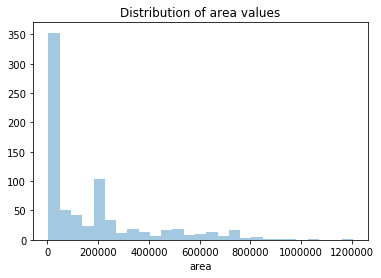

In [21]:
area_hist = sns.distplot(df_cropped["area"], kde=False, rug=False)
# plt.ylabel('count')
plt.title("Distribution of area values")
plt.show(area_hist)

#### Create a histogram of area distribution for each day

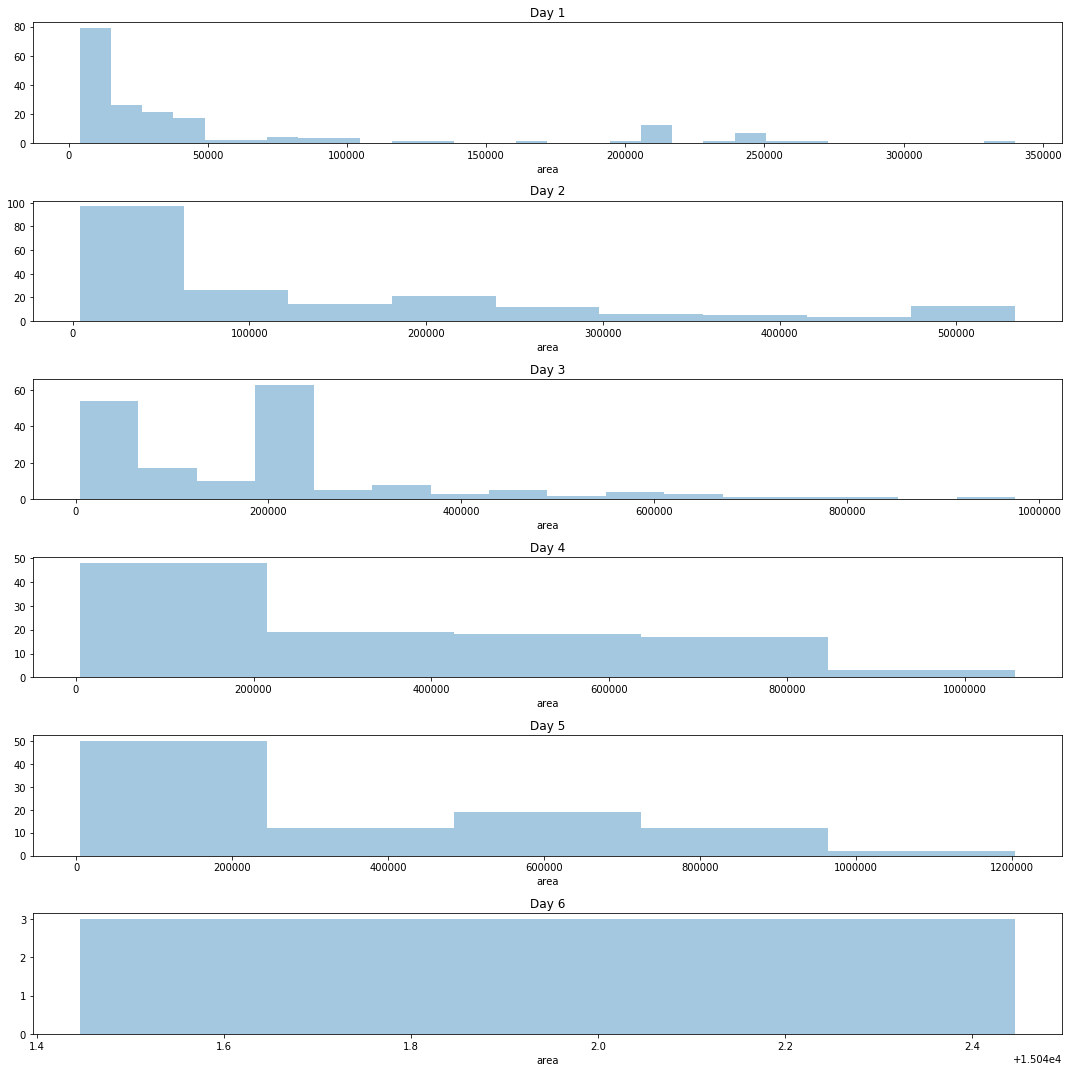

In [22]:
days = list(set(df_cropped["day"])) 

# create average area per day histogram
f, axarr = plt.subplots(len(days), figsize=(15,15))

for i, day in enumerate(days):
    sns.distplot(df_cropped.loc[df["day"] == day, "area"], kde=False, rug=False, ax = axarr[i])
    axarr[i].set_title("Day {}".format(int(day)))

plt.tight_layout()
plt.show()

## heatmap of features with sns.heatmap

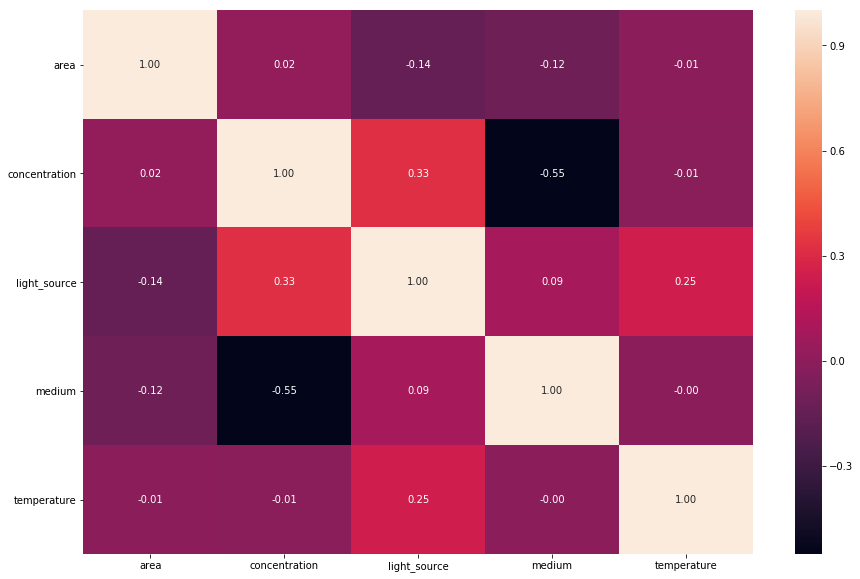

In [23]:
fig, ax = plt.subplots(figsize=(15,10))
heatmap = sns.heatmap(df.drop(["day", "species", "dupl"], axis=1).corr(), annot=True, fmt=".2f")
plt.yticks(rotation=0) 
plt.show(heatmap)

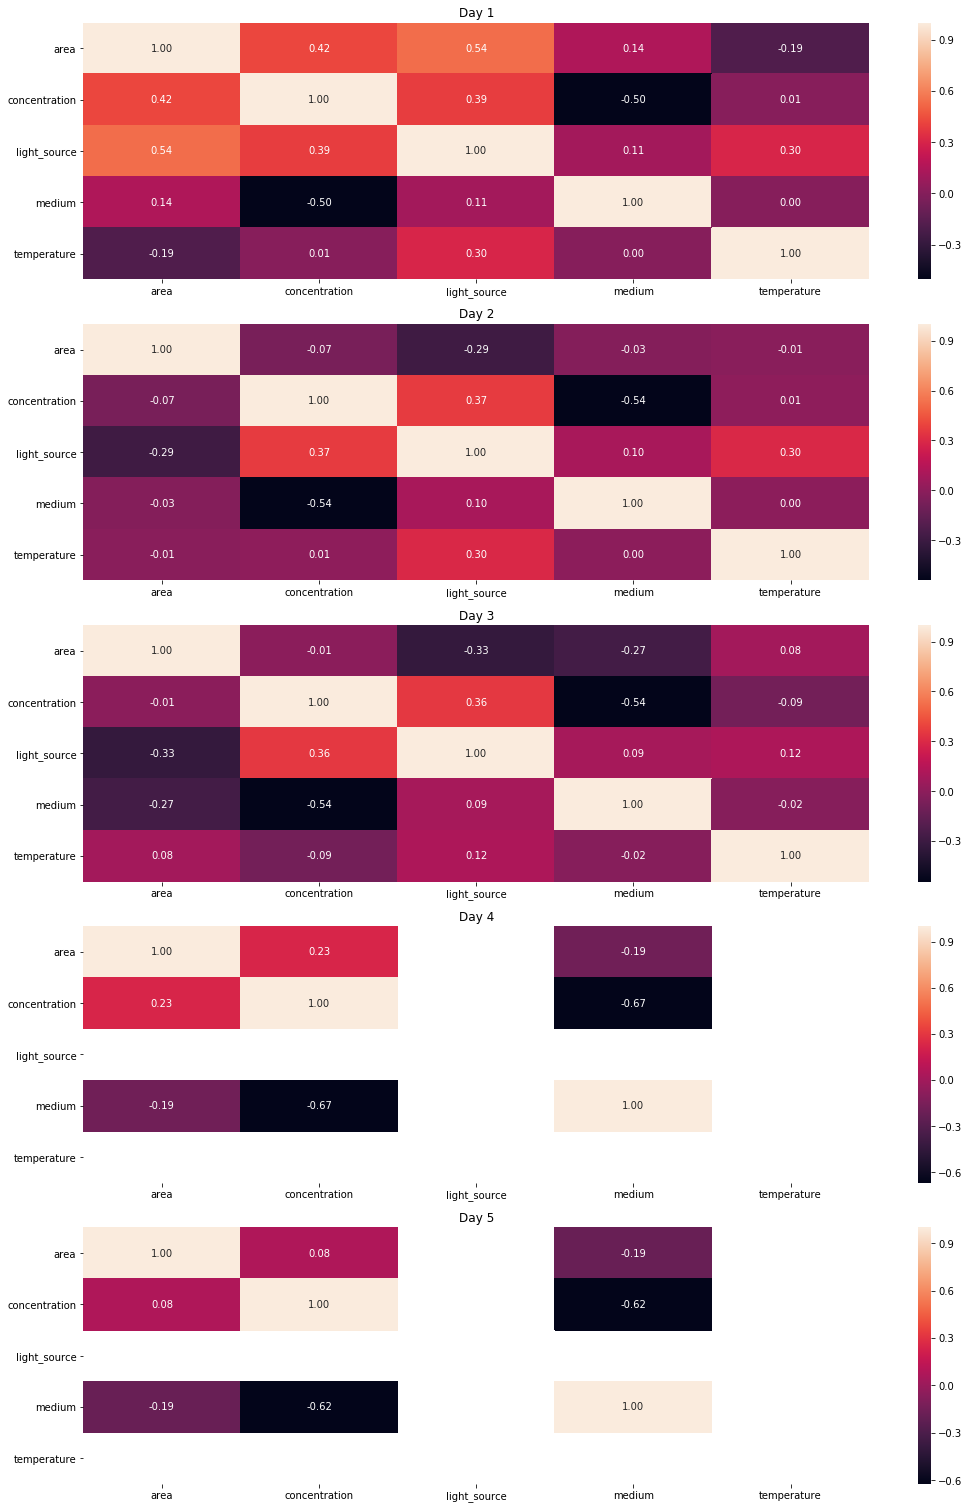

In [35]:
# create feature plot per day
f, axarr = plt.subplots(len(days), figsize=(15,25))

for i, day in enumerate(days):
    try:
        sns.heatmap(df_cropped.loc[df["day"] == day].drop(["day", "species", "dupl"], axis=1).corr(), annot=True, fmt=".2f", ax = axarr[i])
        axarr[i].set_title("Day {}".format(int(day)))
#         axarr[i].set_yticks(rotation=0) 
    except:
        f.delaxes(axarr[i])

f.set_tight_layout('tight')
plt.show()

### calculate change per day in area

In [36]:
simple_df = pd.DataFrame()

N = len(df_cropped)

for i, row in enumerate(df_cropped.iterrows()):
    print("Processing {0} of {1}".format(i+1, N), end = "\r")
#     if row[1]["area_mean"] == 0:
    conc = row[1]["concentration"]
    specie = row[1]["species"]
    media = row[1]["medium"]
    light = row[1]["light_source"]
    temperature = row[1]["temperature"] 
    dupl = row[1]["dupl"]
#         print(row[1])

    matches = df_cropped.loc[(df_cropped["concentration"] == conc) & 
                            (df_cropped["species"] == specie) &
                            (df_cropped["medium"] == media) & 
                            (df_cropped["light_source"] == light) & 
                            (df_cropped["temperature"] == temperature) & 
                            (df_cropped["dupl"] == dupl)]

    days = list(set(matches["day"]))


    for day in days:
        
        try:
        
            day_mean = matches.loc[matches["day"] == day, "area"].mean()


            if day > 1:
                prev_day_mean = matches.loc[matches["day"] == day-1, "area"].mean()
                area_change = day_mean - prev_day_mean

                lfc = np.log2(day_mean) - np.log2(prev_day_mean)
            else:
                area_change = 0
                lfc = 0

            temp = pd.DataFrame({"species": [specie], 
                              "concentration": [conc], 
                              "media": [media],
                              "light_source": [light], 
                              "temperature": [temperature],
                              "dupl": [dupl], 
                              "day": [day], 
                              "area_mean": [day_mean], 
                              "area_change": [area_change], 
                              "area_lfc": [lfc]})

            simple_df = pd.concat([simple_df, temp])
        except:
            pass
            



### backup df to a file

In [3]:
# write backup 
df_cropped.to_csv('data/merged_cropped.csv', sep = ",", index = False)
simple_df.to_csv('data/simple_df.csv', sep = ",", index = False)

NameError: name 'df_cropped' is not defined

df_cropped contains ALL colonies on a plate, e.g. 3 colonies on one plate

In [4]:
df_cropped = pd.read_csv('data/merged_cropped.csv', sep = ",")
df_cropped = df_cropped.iloc[:, 3:]

simple_df contains the average area per plate, area change per plate, and LFC (log fold change) in area per plate. all per day

In [5]:
simple_df = pd.read_csv('data/simple_df.csv', sep = ",")
simple_df = simple_df.iloc[:, 1:]

In [57]:
simple_df.head()

,species,concentration,media,light_source,temperature,dupl,day,area_mean,area_change,area_lfc
0,3,47.5,0,0,30.0,1.0,1.0,32932.268590,0.000000,0.000000
1,3,47.5,0,0,30.0,1.0,2.0,101205.360138,68273.091548,1.619712
2,3,47.5,0,0,30.0,1.0,3.0,224927.562022,123722.201884,1.152175
3,3,47.5,0,0,30.0,1.0,4.0,492914.840151,267987.278129,1.131878
4,3,47.5,0,0,30.0,1.0,5.0,590211.011830,97296.171679,0.259892


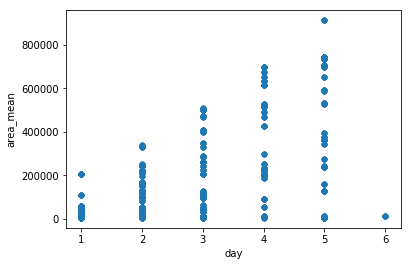

In [6]:
simple_df.plot('day', 'area_mean', kind="scatter")

### split into x and y

In [13]:
y = simple_df["area_mean"]
X = simple_df.drop(["area_mean", "area_change", "area_lfc"], axis = 1)

#### testing different regressors

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

names = [
    "Linear regression",
    "Random forest regressor with 50 estimators",
    "K-nearest neighbors regressor",
    "SGD regressor",
    "Bayesian Ridge Regression",
    "Decision Tree Regression",
    "Support Vector Regression"
]

regressors = [
    LinearRegression(),
    RandomForestRegressor(n_estimators=50),
    KNeighborsRegressor(),
    SGDRegressor(), 
    BayesianRidge(),
    DecisionTreeRegressor(),
    SVR()
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

for name, clf in zip(names, regressors):
    print("Model:", name)
    clf.fit(X_train.values, y_train.values)
    score = clf.score(X_test, y_test)
    print(" Score:", score)
    y_pred = clf.predict(X_test)
    print(" Mean squared error", mean_squared_error(y_test, y_pred))
    print(" Explained variance", explained_variance_score(y_test, y_pred))
    print(" R2 score", r2_score(y_test, y_pred))
    

Model: Linear regression
 Score: 0.3686656329765612
 Mean squared error 28381421721.73814
 Explained variance 0.36918294166451715
 R2 score 0.3686656329765612
Model: Random forest regressor with 50 estimators
 Score: 0.9999921139001582
 Mean squared error 354516.9359387314
 Explained variance 0.999992175399453
 R2 score 0.9999921139001582
Model: K-nearest neighbors regressor
 Score: 0.9998023341747887
 Mean squared error 8885999.936526794
 Explained variance 0.9998035207826202
 R2 score 0.9998023341747887
Model: SGD regressor
 Score: -34222290103.05176
 Mean squared error 1.5384514109473457e+21
 Explained variance -27951190576.321064
 R2 score -34222290103.051765
Model: Bayesian Ridge Regression
 Score: 0.36903338896785687
 Mean squared error 28364889376.241295
 Explained variance 0.3695103844282549
 R2 score 0.36903338896785687
Model: Decision Tree Regression
 Score: 1.0
 Mean squared error 2.4748668936185178e-21
 Explained variance 1.0
 R2 score 1.0
Model: Support Vector Regression
 